In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [ ]:
pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikhilkumarreddyapur","key":"1e36863fe9c1fb77db12906f58dec684"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
#create folder kaggel
!mkdir -p ~/ .kaggle
#copy kaggle.json into kaggle folder
!cp kaggle.json ~/.kaggle/



In [ ]:
#api key to get dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:16<00:00, 140MB/s]
100% 2.29G/2.29G [00:16<00:00, 148MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip 

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
!ls

chest_xray  chest-xray-pneumonia.zip  kaggle.json  sample_data


In [ ]:
# Generate data paths with labels
data_path = '/content/chest_xray/train'
file_paths = []
labels = []

folds = os.listdir(data_path)
for fold in folds:
    fold_path = os.path.join(data_path, fold)
    file_list = os.listdir(fold_path)
    for file in file_list:
        file_path = os.path.join(fold_path, file)
        file_paths.append(file_path)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
file_paths_series = pd.Series(file_paths, name= 'file_paths')
labels_series = pd.Series(labels, name='labels')
df = pd.concat([file_paths_series, labels_series], axis= 1)


In [ ]:
df

,filepaths,labels
0,/content/chest_xray/train/NORMAL/IM-0581-0001....,NORMAL
1,/content/chest_xray/train/NORMAL/IM-0645-0001....,NORMAL
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-05...,NORMAL
3,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,NORMAL
4,/content/chest_xray/train/NORMAL/IM-0405-0001....,NORMAL
...,...,...
5211,/content/chest_xray/train/PNEUMONIA/person1343...,PNEUMONIA
5212,/content/chest_xray/train/PNEUMONIA/person1471...,PNEUMONIA
5213,/content/chest_xray/train/PNEUMONIA/person972_...,PNEUMONIA
5214,/content/chest_xray/train/PNEUMONIA/person712_...,PNEUMONIA


In [ ]:
# Train dataframe
train_data, dummy_data = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# Validation and test dataframe
valid_data, test_data = train_test_split(dummy_data,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# Cropped image size
batch_size = 16
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)

# Recommended: use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_data)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def identity(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=identity)
ts_gen = ImageDataGenerator(preprocessing_function=identity)

train_gen = tr_gen.flow_from_dataframe(train_data, x_col='file_paths', y_col='labels', target_size=image_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_data, x_col='file_paths', y_col='labels', target_size=image_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Note: we will use custom test_batch_size, and make shuffle=False
test_gen = ts_gen.flow_from_dataframe(test_data, x_col='file_paths', y_col='labels', target_size=image_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


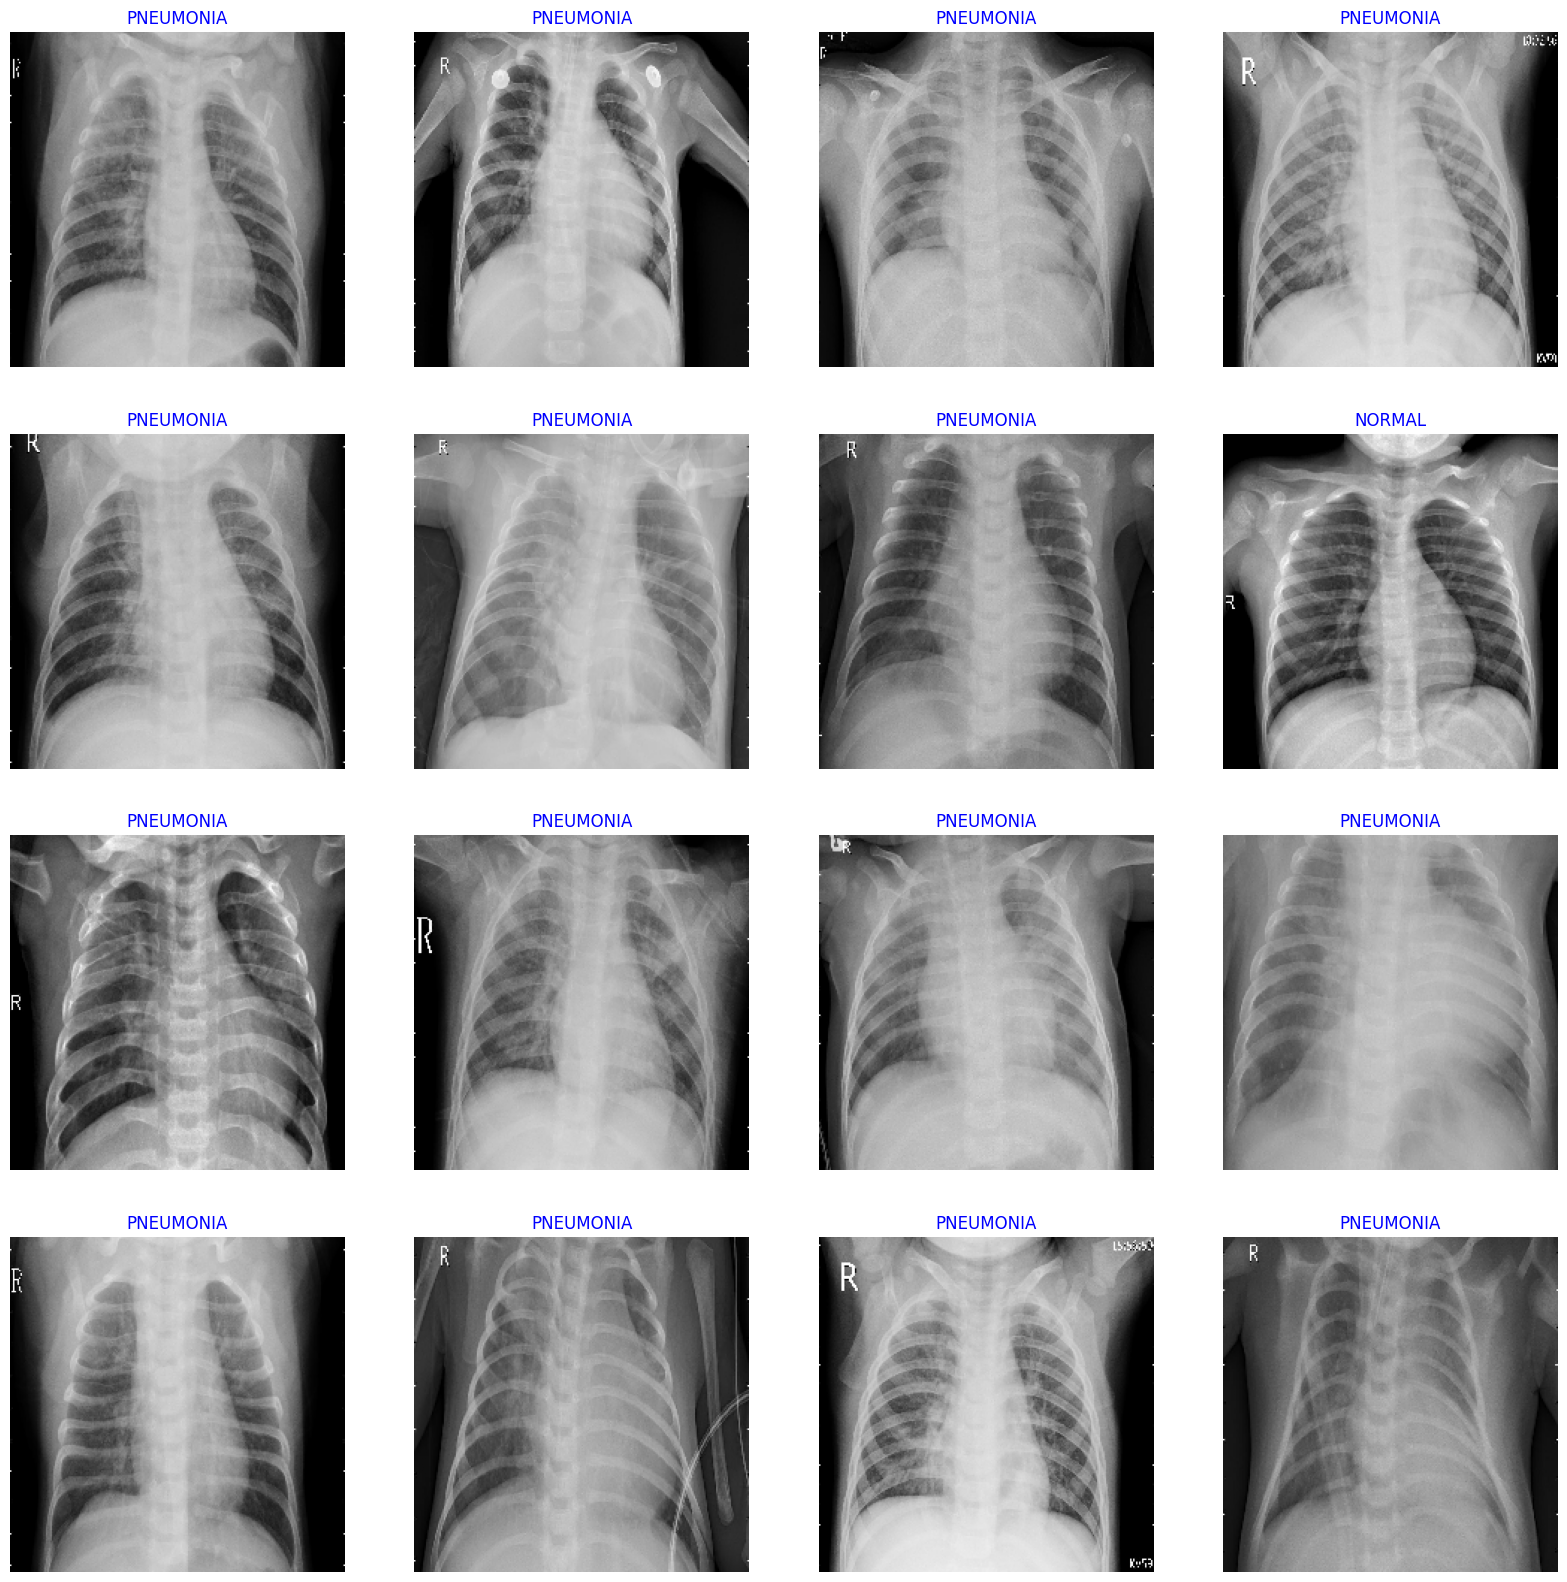

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
class_names = list(g_dict.keys())       # defines list of dictionary's keys (classes), class names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = class_names[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-t

In [ ]:
batch_size = 16   # set batch size for training
num_epochs = 10   # number of all epochs in training

history = model.fit(x=train_generator, epochs=num_epochs, verbose=1, validation_data=validation_generator, 
                    validation_steps=None, shuffle=False)

Epoch 1/10
261/261 [==============================] - 702s 3s/step - loss: 5.0441 - accuracy: 0.9233 - val_loss: 3.4355 - val_accuracy: 0.9169
Epoch 2/10
261/261 [==============================] - 673s 3s/step - loss: 2.6591 - accuracy: 0.9710 - val_loss: 2.1409 - val_accuracy: 0.9121
Epoch 3/10
261/261 [==============================] - 666s 3s/step - loss: 1.6486 - accuracy: 0.9815 - val_loss: 1.2798 - val_accuracy: 0.9888
Epoch 4/10
261/261 [==============================] - 665s 3s/step - loss: 1.0427 - accuracy: 0.9830 - val_loss: 0.7952 - val_accuracy: 0.9888
Epoch 5/10
261/261 [==============================] - 665s 3s/step - loss: 0.6845 - accuracy: 0.9859 - val_loss: 0.5469 - val_accuracy: 0.9872
Epoch 6/10
261/261 [==============================] - 667s 3s/step - loss: 0.4880 - accuracy: 0.9878 - val_loss: 0.4066 - val_accuracy: 0.9904
Epoch 7/10
261/261 [==============================] - 645s 2s/step - loss: 0.3803 - accuracy: 0.9873 - val_loss: 0.3140 - val_accuracy: 0.9920

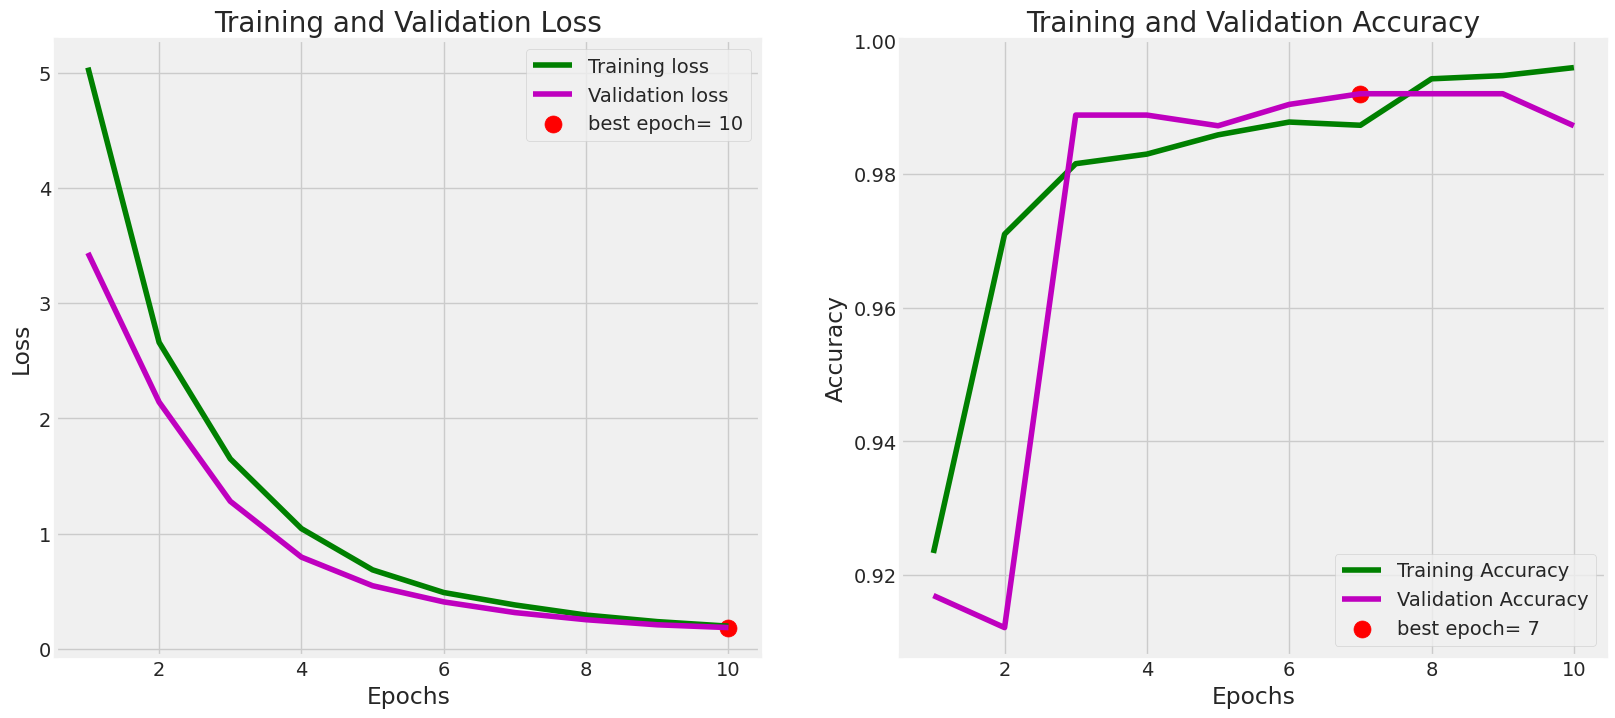

In [ ]:
import matplotlib.pyplot as plt
#Extract training and validation metrics from history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
# Find index of epoch with lowest validation loss and highest validation accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_accuracy)
acc_highest = val_accuracy[index_acc]
# Define epochs list
epochs = [i+1 for i in range(len(train_accuracy))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'g', label= 'Training loss')
plt.plot(epochs, val_loss, 'm', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'g', label= 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'm', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
ts_length = len(test_data)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 19s 2s/step - loss: 0.1779 - accuracy: 0.9952
Train Loss:  0.1593327671289444
Train Accuracy:  1.0
--------------------
Validation Loss:  0.20173560082912445
Validation Accuracy:  0.9829545617103577
--------------------
Test Loss:  0.17787571251392365
Test Accuracy:  0.9952152967453003


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

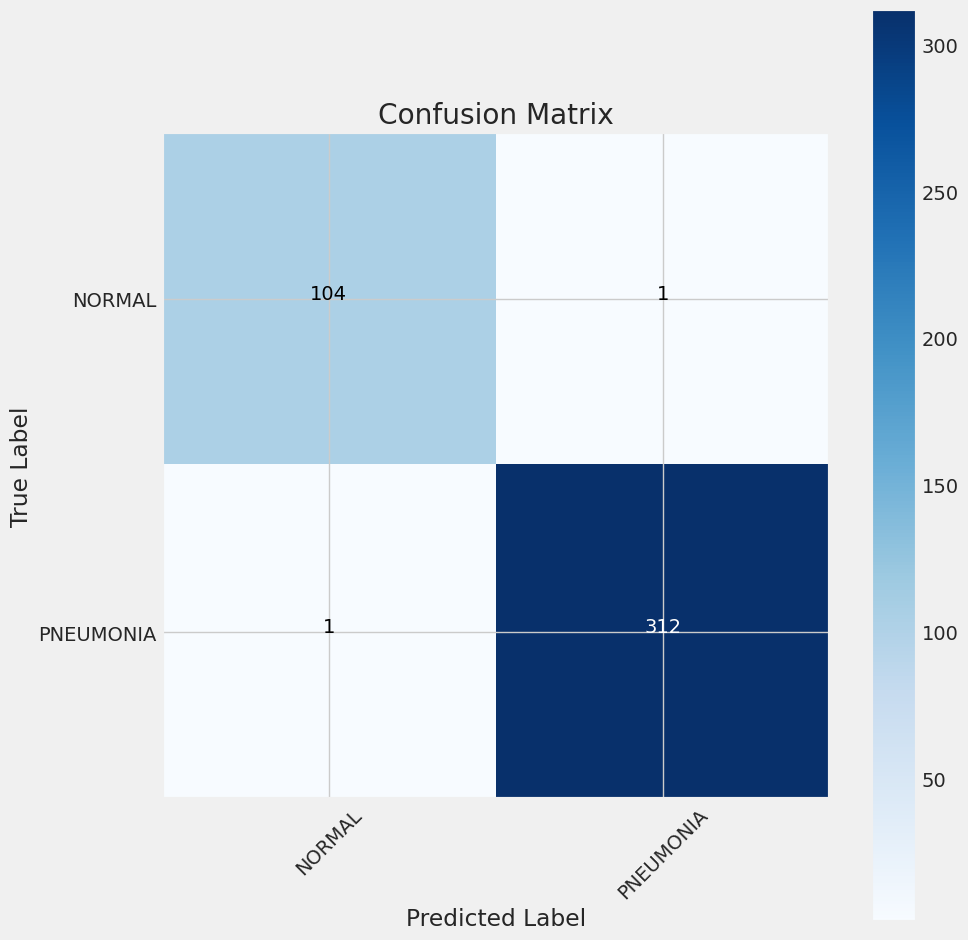

In [ ]:
# Get class labels from the test generator
generator_dict = test_gen.class_indices
classes = list(generator_dict.keys())
# Confusion matrix
confusion_mat = confusion_matrix(test_gen.classes, y_pred)
# Plot the confusion matrix
plt.figure(figsize= (10, 10))
plt.imshow(confusion_mat, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
# Set x and y ticks and labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

# Add text to each cell
thresh = confusion_mat.max() / 2.
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, confusion_mat[i, j], horizontalalignment= 'center', color= 'white' if confusion_mat[i, j] > thresh else 'black')
# Set plot labels
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# Show plot
plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       105
   PNEUMONIA       1.00      1.00      1.00       313

    accuracy                           1.00       418
   macro avg       0.99      0.99      0.99       418
weighted avg       1.00      1.00      1.00       418

